# XGBoost Regression
This notebook demonstrates the use of XGBoost for regression tasks.

## Import Libraries
Import necessary libraries for data manipulation, visualization, and modeling.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Load Dataset
Load the dataset and inspect its structure.

In [2]:
df = pd.read_csv('datasets/luxury_watches_featured.csv')
df.columns

Index(['Brand', 'Model', 'Case Material', 'Strap Material', 'Crystal Material',
       'Dial Color', 'Case Diameter', 'Case Thickness', 'Band Width',
       'Case_Size_Category', 'Case_Proportion', 'Movement Type',
       'Movement_Complexity', 'Power Reserve', 'Complications',
       'Has_Complication', 'Water Resistance', 'Water_Tier', 'Dial_Score',
       'Complication_Score', 'Material_Match', 'Luxury_Index', 'Brand_Tier',
       'Model_Tier', 'Brand_Tier_label_encoded', 'Model_Tier_label_encoded',
       'Brand_Tier_target_encoded', 'Model_Tier_target_encoded', 'Brand_Case',
       'Brand_Crystal', 'Material_Crystal_Movement', 'Price'],
      dtype='object')

In [3]:
num_columns = [
    'Price',
    'Luxury_Index', 'Brand_Tier_label_encoded','Model_Tier_label_encoded', 'Brand_Tier_target_encoded','Model_Tier_target_encoded',
    'Case_Proportion', 'Brand_Case', 'Brand_Crystal', 'Material_Crystal_Movement',
    'Dial_Score', 'Power Reserve'
]

In [4]:
# plt.figure(figsize=(8,8))
# corr_matrix = df[num_columns].corr()
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# plt.show()

In [5]:
corr_matrix = df[num_columns].corr()['Price']
corr_matrix

Price                        1.000000
Luxury_Index                 0.051905
Brand_Tier_label_encoded     0.513461
Model_Tier_label_encoded     0.411628
Brand_Tier_target_encoded    0.789664
Model_Tier_target_encoded    0.768290
Case_Proportion              0.415430
Brand_Case                   0.580539
Brand_Crystal                0.526944
Material_Crystal_Movement    0.386074
Dial_Score                   0.319139
Power Reserve                0.018499
Name: Price, dtype: float64

## Train XGBoost Model
Train the XGBoost model using the training dataset.

In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.inspection import permutation_importance

In [7]:
X = df[[
    'Luxury_Index', 'Brand_Tier_label_encoded','Model_Tier_label_encoded', 'Brand_Tier_target_encoded','Model_Tier_target_encoded',
    'Case_Proportion', 'Brand_Case', 'Brand_Crystal', 'Material_Crystal_Movement',
    'Dial_Score', 'Power Reserve'
]]

y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

perm = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
importances = pd.DataFrame({'feature': X_train.columns, 'importance': perm.importances_mean})
importances = importances.sort_values('importance', ascending=False)

print(importances)

print(f'R2 Score: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

                      feature    importance
1    Brand_Tier_label_encoded  8.216974e-01
5             Case_Proportion  3.590044e-01
0                Luxury_Index  2.985981e-01
10              Power Reserve  8.844768e-02
6                  Brand_Case  6.721090e-02
4   Model_Tier_target_encoded  3.989677e-02
9                  Dial_Score  3.374516e-02
2    Model_Tier_label_encoded  1.963217e-02
8   Material_Crystal_Movement  8.710846e-03
3   Brand_Tier_target_encoded  4.914906e-03
7               Brand_Crystal  2.644730e-07
R2 Score: 0.8541
RMSE: 2712.8225
MAE: 1912.1283


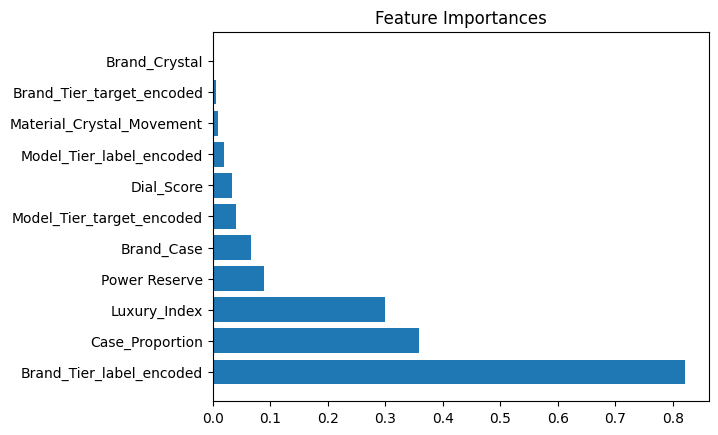

In [8]:
# importances = model.feature_importances_
# features = X.columns
plt.barh(importances['feature'], importances['importance'])
plt.title("Feature Importances")
plt.show()

## Fine-Tune XGBoost Model
Perform hyperparameter tuning to find the best parameters for the XGBoost model.

In [9]:
scorer = make_scorer(r2_score)

xgb_model = xgb.XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring=scorer, cv=3, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best R2 Score: {grid_search.best_score_:.4f}')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'R2 Score: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}
Best R2 Score: 0.8876
R2 Score: 0.8718
RMSE: 2542.6953
MAE: 1882.0742


## Evaluate XGBoost Model
Evaluate the model's performance using the best parameters obtained from fine-tuning.

In [10]:
best_xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    random_state=42
)

best_xgb_model.fit(X_train, y_train)

y_pred = best_xgb_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'R2 Score: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

R2 Score: 0.8718
RMSE: 2542.6953
MAE: 1882.0742
